# Featurize processed data

In [1]:
repo_path = "/Users/johnzhou/research/decision-making"

## Import packages

In [2]:
import sys
sys.path.append(repo_path)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from sklearn.cluster import KMeans
import torch

from src.data.synth_data import SynthBlockDataset as ExperimentData
from src.features.build_features import normalize_features, remove_invalid_fits
from src.models.sigmoidnet import SigmoidNet
from src.models.train import train
from src.visualization.plot_replications import plot_fitted_block
from src.features.fit_curves import epsilon_sigmoid

In [11]:
expt_name = "generate_ssm_histogram"
bigboy = ExperimentData(expt_name, repo_path)
boundary = list(bigboy.agent_labels == 1).index(True)
valid_idxs = bigboy.get_valid_idxs(boundary=boundary)
invalid_idxs = np.arange(bigboy.agent_labels.size)
invalid_idxs = np.delete(invalid_idxs, valid_idxs)
bigboy.build_modeling_feats(include_feff=False, include_block=False)
bigboy.build_modeling_labels()

440209
(1000000, 3)
(1000000,)


array([0., 0., 0., ..., 1., 1., 1.])

[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.01       0.80473684]


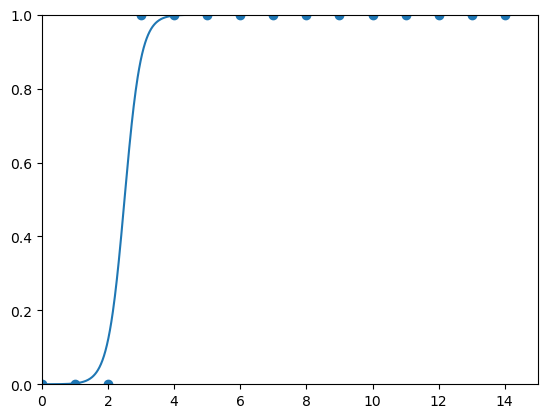

In [7]:
mf = np.argwhere(np.all(bigboy.choice_blocks[:boundary] == np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), axis=1)).flatten()
mb = np.argwhere(np.all(bigboy.choice_blocks[boundary:] == np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), axis=1)).flatten()
mf_idx = mf[0]
mb_idx = mb[0] + boundary

print(bigboy.choice_blocks[mb_idx])
print(bigboy.parameter_labels[mb_idx])

plt.figure()

choice_block = np.expand_dims(bigboy.choice_blocks[mb_idx], axis=0)
x_bounds = (0, choice_block.shape[1])

curve_func = epsilon_sigmoid
params = bigboy.sigmoid_parameters[mf_idx]

plt.plot(np.linspace(*x_bounds, num=1000),
         curve_func(np.linspace(*x_bounds, num=1000), *params))
plt.scatter(range(choice_block.size), list(choice_block))
plt.xlim(x_bounds)
plt.ylim([0, 1])
# plt.legend()
plt.savefig(f'/Users/johnzhou/Desktop/sample_mb_curve.eps', format='eps')



In [12]:
config = OmegaConf.create({
    "name": expt_name,
    "random_seed": 4995,
    "model": {
        "in_features": 3,
        "linear_layers": [32, 8, 4],
        "use_batch_norm": False
    },
    "learning_rate": 1e-4,
    "data": {
        "feature_path": f"{bigboy.data_path}/modeling_features.npy",
        "label_path": f"{bigboy.data_path}/modeling_labels.npy",
        "train_proportion": 0.8,
        "train_batch_size": 128,
        "val_batch_size": 128
    },
    "trainer": {
        "gpus": 0,
        "max_epochs": 1000
    },

})

OmegaConf.save(config=config, f=f"{repo_path}/configs/model_configs/sigmoidnet_train.yaml")

In [9]:
%reload_ext tensorboard
%tensorboard --logdir=$bigboy.data_path/lightning_logs

ModuleNotFoundError: No module named 'tensorboard'

In [13]:
system, trainer = train(
    SigmoidNet,
    OmegaConf.to_container(config),
    experiment_dir=bigboy.data_path,
    checkpoint_name="model")

Global seed set to 4995
/Users/johnzhou/miniconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(


LinearEmbedder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/johnzhou/miniconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Missing logger folder: /Users/johnzhou/research/decision-making/data/processed/generate_ssm_histogram/lightning_logs

  | Name  | Type           | Params
-----------------------------------------
0 | loss  | SupConLoss     | 0     
1 | model | LinearEmbedder | 438   
-----------------------------------------
438       Trainable params
0         Non-trainable params
438       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/johnzhou/miniconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/johnzhou/miniconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  80%|███████▏ | 6240/7813 [00:06<00:01, 909.96it/s, loss=4.52, v_num=0]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████▉| 1560/1563 [00:01<00:00, 1321.00it/s]
Epoch 0: 100%|█| 7813/7813 [00:08<00:00, 969.80it/s, loss=4.52, v_num=0, val_los
Epoch 1:  80%|▊| 6240/7813 [00:07<00:01, 858.32it/s, loss=4.51, v_num=0, val_los
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                      | 0/1563 [00:00<?, ?it/s]
Epoch 1:  80%|▊| 6260/7813 [00:07<00:01, 857.75it/s, loss=4.51, v_num=0, val_los
Epoch 1:  80%|▊| 6280/7813 [00:07<00:01, 858.48it/s, loss=4.51, v_num=0, val_los
Epoch 1:  81%|▊| 6300/7813 [00:07<00:01, 859.48it/s, loss=4.51, v_num=0, val_los
Epoch 1:  81%|▊| 6320/7813 [00:07<00:01, 860.49it/s, loss=4.51, v_num=0, val_los
Epoch 1:  81%|▊| 6340/7813 [00:07<00:01, 861.48it/s, loss=4.51, v_num=0, val_los
Epoch 1:  81%|▊| 6360/7813 [00:07<00:01, 862.53it/s, loss=4.51, v_num=0, val_los
Epoch 1:  82%|▊| 6380/7813 [00:07<00:01, 863.55

Epoch 1:  83%|▊| 6500/7813 [00:07<00:01, 869.40it/s, loss=4.51, v_num=0, val_los
Epoch 1:  83%|▊| 6520/7813 [00:07<00:01, 870.36it/s, loss=4.51, v_num=0, val_los
Epoch 1:  84%|▊| 6540/7813 [00:07<00:01, 871.37it/s, loss=4.51, v_num=0, val_los
Epoch 1:  84%|▊| 6560/7813 [00:07<00:01, 872.35it/s, loss=4.51, v_num=0, val_los
Epoch 1:  84%|▊| 6580/7813 [00:07<00:01, 873.30it/s, loss=4.51, v_num=0, val_los
Epoch 1:  84%|▊| 6600/7813 [00:07<00:01, 874.33it/s, loss=4.51, v_num=0, val_los
Epoch 1:  85%|▊| 6620/7813 [00:07<00:01, 875.38it/s, loss=4.51, v_num=0, val_los
Epoch 1:  85%|▊| 6640/7813 [00:07<00:01, 876.45it/s, loss=4.51, v_num=0, val_los
Epoch 1:  85%|▊| 6660/7813 [00:07<00:01, 877.50it/s, loss=4.51, v_num=0, val_los
Epoch 1:  85%|▊| 6680/7813 [00:07<00:01, 878.52it/s, loss=4.51, v_num=0, val_los
Epoch 1:  86%|▊| 6700/7813 [00:07<00:01, 879.56it/s, loss=4.51, v_num=0, val_los
Epoch 1:  86%|▊| 6720/7813 [00:07<00:01, 880.61it/s, loss=4.51, v_num=0, val_los
Epoch 1:  86%|▊| 6740/7813 [

Epoch 2:  87%|▊| 6800/7813 [00:07<00:01, 889.31it/s, loss=4.51, v_num=0, val_los
Epoch 2:  87%|▊| 6820/7813 [00:07<00:01, 890.23it/s, loss=4.51, v_num=0, val_los
Epoch 2:  88%|▉| 6840/7813 [00:07<00:01, 891.20it/s, loss=4.51, v_num=0, val_los
Epoch 2:  88%|▉| 6860/7813 [00:07<00:01, 892.15it/s, loss=4.51, v_num=0, val_los
Epoch 2:  88%|▉| 6880/7813 [00:07<00:01, 893.11it/s, loss=4.51, v_num=0, val_los
Epoch 2:  88%|▉| 6900/7813 [00:07<00:01, 894.11it/s, loss=4.51, v_num=0, val_los
Epoch 2:  89%|▉| 6920/7813 [00:07<00:00, 895.03it/s, loss=4.51, v_num=0, val_los
Epoch 2:  89%|▉| 6940/7813 [00:07<00:00, 896.04it/s, loss=4.51, v_num=0, val_los
Epoch 2:  89%|▉| 6960/7813 [00:07<00:00, 896.97it/s, loss=4.51, v_num=0, val_los
Epoch 2:  89%|▉| 6980/7813 [00:07<00:00, 897.89it/s, loss=4.51, v_num=0, val_los
Epoch 2:  90%|▉| 7000/7813 [00:07<00:00, 898.85it/s, loss=4.51, v_num=0, val_los
Epoch 2:  90%|▉| 7020/7813 [00:07<00:00, 899.76it/s, loss=4.51, v_num=0, val_los
Epoch 2:  90%|▉| 7040/7813 [

Epoch 3:  91%|▉| 7100/7813 [00:08<00:00, 868.78it/s, loss=4.51, v_num=0, val_los
Epoch 3:  91%|▉| 7120/7813 [00:08<00:00, 869.54it/s, loss=4.51, v_num=0, val_los
Epoch 3:  91%|▉| 7140/7813 [00:08<00:00, 870.38it/s, loss=4.51, v_num=0, val_los
Epoch 3:  92%|▉| 7160/7813 [00:08<00:00, 871.16it/s, loss=4.51, v_num=0, val_los
Epoch 3:  92%|▉| 7180/7813 [00:08<00:00, 871.99it/s, loss=4.51, v_num=0, val_los
Epoch 3:  92%|▉| 7200/7813 [00:08<00:00, 872.82it/s, loss=4.51, v_num=0, val_los
Epoch 3:  92%|▉| 7220/7813 [00:08<00:00, 873.59it/s, loss=4.51, v_num=0, val_los
Epoch 3:  93%|▉| 7240/7813 [00:08<00:00, 874.36it/s, loss=4.51, v_num=0, val_los
Epoch 3:  93%|▉| 7260/7813 [00:08<00:00, 875.01it/s, loss=4.51, v_num=0, val_los
Epoch 3:  93%|▉| 7280/7813 [00:08<00:00, 875.73it/s, loss=4.51, v_num=0, val_los
Epoch 3:  93%|▉| 7300/7813 [00:08<00:00, 876.44it/s, loss=4.51, v_num=0, val_los
Epoch 3:  94%|▉| 7320/7813 [00:08<00:00, 877.16it/s, loss=4.51, v_num=0, val_los
Epoch 3:  94%|▉| 7340/7813 [

Epoch 4:  95%|▉| 7400/7813 [00:08<00:00, 838.13it/s, loss=4.51, v_num=0, val_los
Epoch 4:  95%|▉| 7420/7813 [00:08<00:00, 834.29it/s, loss=4.51, v_num=0, val_los
Epoch 4:  95%|▉| 7440/7813 [00:08<00:00, 828.70it/s, loss=4.51, v_num=0, val_los
Epoch 4:  95%|▉| 7460/7813 [00:09<00:00, 818.07it/s, loss=4.51, v_num=0, val_los
Epoch 4:  96%|▉| 7480/7813 [00:09<00:00, 812.55it/s, loss=4.51, v_num=0, val_los
Epoch 4:  96%|▉| 7500/7813 [00:09<00:00, 808.55it/s, loss=4.51, v_num=0, val_los
Epoch 4:  96%|▉| 7520/7813 [00:09<00:00, 805.25it/s, loss=4.51, v_num=0, val_los
Epoch 4:  97%|▉| 7540/7813 [00:09<00:00, 801.42it/s, loss=4.51, v_num=0, val_los
Epoch 4:  97%|▉| 7560/7813 [00:09<00:00, 798.23it/s, loss=4.51, v_num=0, val_los
Epoch 4:  97%|▉| 7580/7813 [00:09<00:00, 793.58it/s, loss=4.51, v_num=0, val_los
Epoch 4:  97%|▉| 7600/7813 [00:09<00:00, 786.21it/s, loss=4.51, v_num=0, val_los
Epoch 4:  98%|▉| 7620/7813 [00:09<00:00, 781.16it/s, loss=4.51, v_num=0, val_los
Epoch 4:  98%|▉| 7640/7813 [

Epoch 5:  99%|▉| 7700/7813 [00:39<00:00, 194.14it/s, loss=4.51, v_num=0, val_los
Epoch 5:  99%|▉| 7720/7813 [00:39<00:00, 194.25it/s, loss=4.51, v_num=0, val_los
Epoch 5:  99%|▉| 7740/7813 [00:39<00:00, 194.43it/s, loss=4.51, v_num=0, val_los
Epoch 5:  99%|▉| 7760/7813 [00:39<00:00, 194.50it/s, loss=4.51, v_num=0, val_los
Epoch 5: 100%|▉| 7780/7813 [00:39<00:00, 194.70it/s, loss=4.51, v_num=0, val_los
Epoch 5: 100%|▉| 7800/7813 [00:40<00:00, 194.82it/s, loss=4.51, v_num=0, val_los
Validation DataLoader 0: 100%|████████████▉| 1560/1563 [00:05<00:00, 276.21it/s]
Epoch 5: 100%|█| 7813/7813 [00:40<00:00, 194.76it/s, loss=4.51, v_num=0, val_los
Epoch 6:  80%|▊| 6240/7813 [00:23<00:05, 265.68it/s, loss=4.51, v_num=0, val_los
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                      | 0/1563 [00:00<?, ?it/s]
Epoch 6:  80%|▊| 6260/7813 [00:23<00:05, 266.25it/s, loss=4.51, v_num=0, val_los
Epoch 6:  80%|▊| 6280/7813 [00:23<00:05, 266.93it/s, loss=4.51, v_num=0, val_l

Epoch 7:  81%|▊| 6340/7813 [00:07<00:01, 816.16it/s, loss=4.51, v_num=0, val_los
Epoch 7:  81%|▊| 6360/7813 [00:07<00:01, 817.15it/s, loss=4.51, v_num=0, val_los
Epoch 7:  82%|▊| 6380/7813 [00:07<00:01, 818.14it/s, loss=4.51, v_num=0, val_los
Epoch 7:  82%|▊| 6400/7813 [00:07<00:01, 819.24it/s, loss=4.51, v_num=0, val_los
Epoch 7:  82%|▊| 6420/7813 [00:07<00:01, 820.30it/s, loss=4.51, v_num=0, val_los
Epoch 7:  82%|▊| 6440/7813 [00:07<00:01, 821.39it/s, loss=4.51, v_num=0, val_los
Epoch 7:  83%|▊| 6460/7813 [00:07<00:01, 822.51it/s, loss=4.51, v_num=0, val_los
Epoch 7:  83%|▊| 6480/7813 [00:07<00:01, 823.57it/s, loss=4.51, v_num=0, val_los
Epoch 7:  83%|▊| 6500/7813 [00:07<00:01, 824.60it/s, loss=4.51, v_num=0, val_los
Epoch 7:  83%|▊| 6520/7813 [00:07<00:01, 825.67it/s, loss=4.51, v_num=0, val_los
Epoch 7:  84%|▊| 6540/7813 [00:07<00:01, 826.73it/s, loss=4.51, v_num=0, val_los
Epoch 7:  84%|▊| 6560/7813 [00:07<00:01, 827.79it/s, loss=4.51, v_num=0, val_los
Epoch 7:  84%|▊| 6580/7813 [

Epoch 8:  85%|▊| 6640/7813 [00:07<00:01, 875.42it/s, loss=4.51, v_num=0, val_los
Epoch 8:  85%|▊| 6660/7813 [00:07<00:01, 876.36it/s, loss=4.51, v_num=0, val_los
Epoch 8:  85%|▊| 6680/7813 [00:07<00:01, 877.23it/s, loss=4.51, v_num=0, val_los
Epoch 8:  86%|▊| 6700/7813 [00:07<00:01, 878.20it/s, loss=4.51, v_num=0, val_los
Epoch 8:  86%|▊| 6720/7813 [00:07<00:01, 879.21it/s, loss=4.51, v_num=0, val_los
Epoch 8:  86%|▊| 6740/7813 [00:07<00:01, 880.24it/s, loss=4.51, v_num=0, val_los
Epoch 8:  87%|▊| 6760/7813 [00:07<00:01, 881.28it/s, loss=4.51, v_num=0, val_los
Epoch 8:  87%|▊| 6780/7813 [00:07<00:01, 882.30it/s, loss=4.51, v_num=0, val_los
Epoch 8:  87%|▊| 6800/7813 [00:07<00:01, 883.32it/s, loss=4.51, v_num=0, val_los
Epoch 8:  87%|▊| 6820/7813 [00:07<00:01, 884.34it/s, loss=4.51, v_num=0, val_los
Epoch 8:  88%|▉| 6840/7813 [00:07<00:01, 885.32it/s, loss=4.51, v_num=0, val_los
Epoch 8:  88%|▉| 6860/7813 [00:07<00:01, 886.34it/s, loss=4.51, v_num=0, val_los
Epoch 8:  88%|▉| 6880/7813 [

Epoch 9:  89%|▉| 6940/7813 [00:07<00:00, 903.50it/s, loss=4.51, v_num=0, val_los
Epoch 9:  89%|▉| 6960/7813 [00:07<00:00, 904.40it/s, loss=4.51, v_num=0, val_los
Epoch 9:  89%|▉| 6980/7813 [00:07<00:00, 905.26it/s, loss=4.51, v_num=0, val_los
Epoch 9:  90%|▉| 7000/7813 [00:07<00:00, 906.13it/s, loss=4.51, v_num=0, val_los
Epoch 9:  90%|▉| 7020/7813 [00:07<00:00, 907.02it/s, loss=4.51, v_num=0, val_los
Epoch 9:  90%|▉| 7040/7813 [00:07<00:00, 907.94it/s, loss=4.51, v_num=0, val_los
Epoch 9:  90%|▉| 7060/7813 [00:07<00:00, 908.85it/s, loss=4.51, v_num=0, val_los
Epoch 9:  91%|▉| 7080/7813 [00:07<00:00, 909.75it/s, loss=4.51, v_num=0, val_los
Epoch 9:  91%|▉| 7100/7813 [00:07<00:00, 910.72it/s, loss=4.51, v_num=0, val_los
Epoch 9:  91%|▉| 7120/7813 [00:07<00:00, 911.66it/s, loss=4.51, v_num=0, val_los
Epoch 9:  91%|▉| 7140/7813 [00:07<00:00, 912.59it/s, loss=4.51, v_num=0, val_los
Epoch 9:  92%|▉| 7160/7813 [00:07<00:00, 913.46it/s, loss=4.51, v_num=0, val_los
Epoch 9:  92%|▉| 7180/7813 [

Epoch 10:  93%|▉| 7240/7813 [00:07<00:00, 925.16it/s, loss=4.51, v_num=0, val_lo
Epoch 10:  93%|▉| 7260/7813 [00:07<00:00, 925.99it/s, loss=4.51, v_num=0, val_lo
Epoch 10:  93%|▉| 7280/7813 [00:07<00:00, 926.79it/s, loss=4.51, v_num=0, val_lo
Epoch 10:  93%|▉| 7300/7813 [00:07<00:00, 927.68it/s, loss=4.51, v_num=0, val_lo
Epoch 10:  94%|▉| 7320/7813 [00:07<00:00, 928.53it/s, loss=4.51, v_num=0, val_lo
Epoch 10:  94%|▉| 7340/7813 [00:07<00:00, 929.41it/s, loss=4.51, v_num=0, val_lo
Epoch 10:  94%|▉| 7360/7813 [00:07<00:00, 930.32it/s, loss=4.51, v_num=0, val_lo
Epoch 10:  94%|▉| 7380/7813 [00:07<00:00, 931.27it/s, loss=4.51, v_num=0, val_lo
Epoch 10:  95%|▉| 7400/7813 [00:07<00:00, 932.16it/s, loss=4.51, v_num=0, val_lo
Epoch 10:  95%|▉| 7420/7813 [00:07<00:00, 933.00it/s, loss=4.51, v_num=0, val_lo
Epoch 10:  95%|▉| 7440/7813 [00:07<00:00, 933.85it/s, loss=4.51, v_num=0, val_lo
Epoch 10:  95%|▉| 7460/7813 [00:07<00:00, 934.65it/s, loss=4.51, v_num=0, val_lo
Epoch 10:  96%|▉| 7480/7813 

Epoch 11:  97%|▉| 7540/7813 [00:07<00:00, 943.15it/s, loss=4.51, v_num=0, val_lo
Epoch 11:  97%|▉| 7560/7813 [00:08<00:00, 943.94it/s, loss=4.51, v_num=0, val_lo
Epoch 11:  97%|▉| 7580/7813 [00:08<00:00, 944.81it/s, loss=4.51, v_num=0, val_lo
Epoch 11:  97%|▉| 7600/7813 [00:08<00:00, 945.67it/s, loss=4.51, v_num=0, val_lo
Epoch 11:  98%|▉| 7620/7813 [00:08<00:00, 946.56it/s, loss=4.51, v_num=0, val_lo
Epoch 11:  98%|▉| 7640/7813 [00:08<00:00, 947.47it/s, loss=4.51, v_num=0, val_lo
Epoch 11:  98%|▉| 7660/7813 [00:08<00:00, 948.37it/s, loss=4.51, v_num=0, val_lo
Epoch 11:  98%|▉| 7680/7813 [00:08<00:00, 949.25it/s, loss=4.51, v_num=0, val_lo
Epoch 11:  99%|▉| 7700/7813 [00:08<00:00, 950.10it/s, loss=4.51, v_num=0, val_lo
Epoch 11:  99%|▉| 7720/7813 [00:08<00:00, 950.88it/s, loss=4.51, v_num=0, val_lo
Epoch 11:  99%|▉| 7740/7813 [00:08<00:00, 951.72it/s, loss=4.51, v_num=0, val_lo
Epoch 11:  99%|▉| 7760/7813 [00:08<00:00, 952.53it/s, loss=4.51, v_num=0, val_lo
Epoch 11: 100%|▉| 7780/7813 

Epoch 12: 100%|█| 7813/7813 [00:08<00:00, 975.77it/s, loss=4.51, v_num=0, val_lo
Epoch 13:  80%|▊| 6240/7813 [00:06<00:01, 906.33it/s, loss=4.51, v_num=0, val_lo
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                      | 0/1563 [00:00<?, ?it/s]
Epoch 13:  80%|▊| 6260/7813 [00:06<00:01, 906.43it/s, loss=4.51, v_num=0, val_lo
Epoch 13:  80%|▊| 6280/7813 [00:06<00:01, 907.53it/s, loss=4.51, v_num=0, val_lo
Epoch 13:  81%|▊| 6300/7813 [00:06<00:01, 908.65it/s, loss=4.51, v_num=0, val_lo
Epoch 13:  81%|▊| 6320/7813 [00:06<00:01, 909.81it/s, loss=4.51, v_num=0, val_lo
Epoch 13:  81%|▊| 6340/7813 [00:06<00:01, 910.93it/s, loss=4.51, v_num=0, val_lo
Epoch 13:  81%|▊| 6360/7813 [00:06<00:01, 912.05it/s, loss=4.51, v_num=0, val_lo
Epoch 13:  82%|▊| 6380/7813 [00:06<00:01, 913.14it/s, loss=4.51, v_num=0, val_lo
Epoch 13:  82%|▊| 6400/7813 [00:07<00:01, 914.25it/s, loss=4.51, v_num=0, val_lo
Epoch 13:  82%|▊| 6420/7813 [00:07<00:01, 915.35it/s, loss=4.51, v_num=0, val_

Epoch 14:  83%|▊| 6480/7813 [00:07<00:01, 877.02it/s, loss=4.51, v_num=0, val_lo
Epoch 14:  83%|▊| 6500/7813 [00:07<00:01, 877.98it/s, loss=4.51, v_num=0, val_lo
Epoch 14:  83%|▊| 6520/7813 [00:07<00:01, 878.95it/s, loss=4.51, v_num=0, val_lo
Epoch 14:  84%|▊| 6540/7813 [00:07<00:01, 880.00it/s, loss=4.51, v_num=0, val_lo
Epoch 14:  84%|▊| 6560/7813 [00:07<00:01, 881.04it/s, loss=4.51, v_num=0, val_lo
Epoch 14:  84%|▊| 6580/7813 [00:07<00:01, 882.09it/s, loss=4.51, v_num=0, val_lo
Epoch 14:  84%|▊| 6600/7813 [00:07<00:01, 883.13it/s, loss=4.51, v_num=0, val_lo
Epoch 14:  85%|▊| 6620/7813 [00:07<00:01, 884.20it/s, loss=4.51, v_num=0, val_lo
Epoch 14:  85%|▊| 6640/7813 [00:07<00:01, 885.23it/s, loss=4.51, v_num=0, val_lo
Epoch 14:  85%|▊| 6660/7813 [00:07<00:01, 886.29it/s, loss=4.51, v_num=0, val_lo
Epoch 14:  85%|▊| 6680/7813 [00:07<00:01, 887.32it/s, loss=4.51, v_num=0, val_lo
Epoch 14:  86%|▊| 6700/7813 [00:07<00:01, 888.32it/s, loss=4.51, v_num=0, val_lo
Epoch 14:  86%|▊| 6720/7813 

Epoch 15:  87%|▊| 6780/7813 [00:07<00:01, 899.48it/s, loss=4.51, v_num=0, val_lo
Epoch 15:  87%|▊| 6800/7813 [00:07<00:01, 900.46it/s, loss=4.51, v_num=0, val_lo
Epoch 15:  87%|▊| 6820/7813 [00:07<00:01, 901.40it/s, loss=4.51, v_num=0, val_lo
Epoch 15:  88%|▉| 6840/7813 [00:07<00:01, 902.35it/s, loss=4.51, v_num=0, val_lo
Epoch 15:  88%|▉| 6860/7813 [00:07<00:01, 903.38it/s, loss=4.51, v_num=0, val_lo
Epoch 15:  88%|▉| 6880/7813 [00:07<00:01, 904.39it/s, loss=4.51, v_num=0, val_lo
Epoch 15:  88%|▉| 6900/7813 [00:07<00:01, 905.42it/s, loss=4.51, v_num=0, val_lo
Epoch 15:  89%|▉| 6920/7813 [00:07<00:00, 906.43it/s, loss=4.51, v_num=0, val_lo
Epoch 15:  89%|▉| 6940/7813 [00:07<00:00, 907.44it/s, loss=4.51, v_num=0, val_lo
Epoch 15:  89%|▉| 6960/7813 [00:07<00:00, 908.48it/s, loss=4.51, v_num=0, val_lo
Epoch 15:  89%|▉| 6980/7813 [00:07<00:00, 909.47it/s, loss=4.51, v_num=0, val_lo
Epoch 15:  90%|▉| 7000/7813 [00:07<00:00, 910.49it/s, loss=4.51, v_num=0, val_lo
Epoch 15:  90%|▉| 7020/7813 

Epoch 16:  91%|▉| 7080/7813 [00:07<00:00, 920.51it/s, loss=4.51, v_num=0, val_lo
Epoch 16:  91%|▉| 7100/7813 [00:07<00:00, 921.38it/s, loss=4.51, v_num=0, val_lo
Epoch 16:  91%|▉| 7120/7813 [00:07<00:00, 922.29it/s, loss=4.51, v_num=0, val_lo
Epoch 16:  91%|▉| 7140/7813 [00:07<00:00, 923.18it/s, loss=4.51, v_num=0, val_lo
Epoch 16:  92%|▉| 7160/7813 [00:07<00:00, 924.13it/s, loss=4.51, v_num=0, val_lo
Epoch 16:  92%|▉| 7180/7813 [00:07<00:00, 925.04it/s, loss=4.51, v_num=0, val_lo
Epoch 16:  92%|▉| 7200/7813 [00:07<00:00, 926.00it/s, loss=4.51, v_num=0, val_lo
Epoch 16:  92%|▉| 7220/7813 [00:07<00:00, 926.93it/s, loss=4.51, v_num=0, val_lo
Epoch 16:  93%|▉| 7240/7813 [00:07<00:00, 927.90it/s, loss=4.51, v_num=0, val_lo
Epoch 16:  93%|▉| 7260/7813 [00:07<00:00, 928.84it/s, loss=4.51, v_num=0, val_lo
Epoch 16:  93%|▉| 7280/7813 [00:07<00:00, 929.79it/s, loss=4.51, v_num=0, val_lo
Epoch 16:  93%|▉| 7300/7813 [00:07<00:00, 930.74it/s, loss=4.51, v_num=0, val_lo
Epoch 16:  94%|▉| 7320/7813 

Epoch 17:  94%|▉| 7380/7813 [00:08<00:00, 920.57it/s, loss=4.51, v_num=0, val_lo
Epoch 17:  95%|▉| 7400/7813 [00:08<00:00, 921.39it/s, loss=4.51, v_num=0, val_lo
Epoch 17:  95%|▉| 7420/7813 [00:08<00:00, 922.20it/s, loss=4.51, v_num=0, val_lo
Epoch 17:  95%|▉| 7440/7813 [00:08<00:00, 923.09it/s, loss=4.51, v_num=0, val_lo
Epoch 17:  95%|▉| 7460/7813 [00:08<00:00, 923.98it/s, loss=4.51, v_num=0, val_lo
Epoch 17:  96%|▉| 7480/7813 [00:08<00:00, 924.92it/s, loss=4.51, v_num=0, val_lo
Epoch 17:  96%|▉| 7500/7813 [00:08<00:00, 925.83it/s, loss=4.51, v_num=0, val_lo
Epoch 17:  96%|▉| 7520/7813 [00:08<00:00, 926.77it/s, loss=4.51, v_num=0, val_lo
Epoch 17:  97%|▉| 7540/7813 [00:08<00:00, 927.69it/s, loss=4.51, v_num=0, val_lo
Epoch 17:  97%|▉| 7560/7813 [00:08<00:00, 928.62it/s, loss=4.51, v_num=0, val_lo
Epoch 17:  97%|▉| 7580/7813 [00:08<00:00, 929.55it/s, loss=4.51, v_num=0, val_lo
Epoch 17:  97%|▉| 7600/7813 [00:08<00:00, 930.47it/s, loss=4.51, v_num=0, val_lo
Epoch 17:  98%|▉| 7620/7813 

Epoch 18:  98%|▉| 7680/7813 [00:07<00:00, 969.30it/s, loss=4.51, v_num=0, val_lo
Epoch 18:  99%|▉| 7700/7813 [00:07<00:00, 970.02it/s, loss=4.51, v_num=0, val_lo
Epoch 18:  99%|▉| 7720/7813 [00:07<00:00, 970.80it/s, loss=4.51, v_num=0, val_lo
Epoch 18:  99%|▉| 7740/7813 [00:07<00:00, 971.59it/s, loss=4.51, v_num=0, val_lo
Epoch 18:  99%|▉| 7760/7813 [00:07<00:00, 972.39it/s, loss=4.51, v_num=0, val_lo
Epoch 18: 100%|▉| 7780/7813 [00:07<00:00, 973.21it/s, loss=4.51, v_num=0, val_lo
Epoch 18: 100%|▉| 7800/7813 [00:08<00:00, 974.05it/s, loss=4.51, v_num=0, val_lo
Validation DataLoader 0: 100%|███████████▉| 1560/1563 [00:01<00:00, 1395.01it/s]
Epoch 18: 100%|█| 7813/7813 [00:08<00:00, 974.29it/s, loss=4.51, v_num=0, val_lo
Epoch 19:  80%|▊| 6240/7813 [00:06<00:01, 905.95it/s, loss=4.51, v_num=0, val_lo
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                      | 0/1563 [00:00<?, ?it/s]
Epoch 19:  80%|▊| 6260/7813 [00:06<00:01, 906.02it/s, loss=4.51, v_num=0, val_

Epoch 20:  81%|▊| 6320/7813 [00:07<00:01, 867.69it/s, loss=4.51, v_num=0, val_lo
Epoch 20:  81%|▊| 6340/7813 [00:07<00:01, 868.72it/s, loss=4.51, v_num=0, val_lo
Epoch 20:  81%|▊| 6360/7813 [00:07<00:01, 869.76it/s, loss=4.51, v_num=0, val_lo
Epoch 20:  82%|▊| 6380/7813 [00:07<00:01, 870.87it/s, loss=4.51, v_num=0, val_lo
Epoch 20:  82%|▊| 6400/7813 [00:07<00:01, 871.95it/s, loss=4.51, v_num=0, val_lo
Epoch 20:  82%|▊| 6420/7813 [00:07<00:01, 873.06it/s, loss=4.51, v_num=0, val_lo
Epoch 20:  82%|▊| 6440/7813 [00:07<00:01, 874.14it/s, loss=4.51, v_num=0, val_lo
Epoch 20:  83%|▊| 6460/7813 [00:07<00:01, 875.23it/s, loss=4.51, v_num=0, val_lo
Epoch 20:  83%|▊| 6480/7813 [00:07<00:01, 876.33it/s, loss=4.51, v_num=0, val_lo
Epoch 20:  83%|▊| 6500/7813 [00:07<00:01, 877.43it/s, loss=4.51, v_num=0, val_lo
Epoch 20:  83%|▊| 6520/7813 [00:07<00:01, 878.47it/s, loss=4.51, v_num=0, val_lo
Epoch 20:  84%|▊| 6540/7813 [00:07<00:01, 879.52it/s, loss=4.51, v_num=0, val_lo
Epoch 20:  84%|▊| 6560/7813 

Epoch 21:  85%|▊| 6620/7813 [00:07<00:01, 880.83it/s, loss=4.51, v_num=0, val_lo
Epoch 21:  85%|▊| 6640/7813 [00:07<00:01, 881.78it/s, loss=4.51, v_num=0, val_lo
Epoch 21:  85%|▊| 6660/7813 [00:07<00:01, 882.77it/s, loss=4.51, v_num=0, val_lo
Epoch 21:  85%|▊| 6680/7813 [00:07<00:01, 883.81it/s, loss=4.51, v_num=0, val_lo
Epoch 21:  86%|▊| 6700/7813 [00:07<00:01, 884.83it/s, loss=4.51, v_num=0, val_lo
Epoch 21:  86%|▊| 6720/7813 [00:07<00:01, 885.84it/s, loss=4.51, v_num=0, val_lo
Epoch 21:  86%|▊| 6740/7813 [00:07<00:01, 886.90it/s, loss=4.51, v_num=0, val_lo
Epoch 21:  87%|▊| 6760/7813 [00:07<00:01, 887.95it/s, loss=4.51, v_num=0, val_lo
Epoch 21:  87%|▊| 6780/7813 [00:07<00:01, 889.00it/s, loss=4.51, v_num=0, val_lo
Epoch 21:  87%|▊| 6800/7813 [00:07<00:01, 890.04it/s, loss=4.51, v_num=0, val_lo
Epoch 21:  87%|▊| 6820/7813 [00:07<00:01, 891.07it/s, loss=4.51, v_num=0, val_lo
Epoch 21:  88%|▉| 6840/7813 [00:07<00:01, 892.12it/s, loss=4.51, v_num=0, val_lo
Epoch 21:  88%|▉| 6860/7813 

Epoch 22:  89%|▉| 6920/7813 [00:07<00:00, 907.91it/s, loss=4.51, v_num=0, val_lo
Epoch 22:  89%|▉| 6940/7813 [00:07<00:00, 908.80it/s, loss=4.51, v_num=0, val_lo
Epoch 22:  89%|▉| 6960/7813 [00:07<00:00, 909.74it/s, loss=4.51, v_num=0, val_lo
Epoch 22:  89%|▉| 6980/7813 [00:07<00:00, 910.74it/s, loss=4.51, v_num=0, val_lo
Epoch 22:  90%|▉| 7000/7813 [00:07<00:00, 911.73it/s, loss=4.51, v_num=0, val_lo
Epoch 22:  90%|▉| 7020/7813 [00:07<00:00, 912.74it/s, loss=4.51, v_num=0, val_lo
Epoch 22:  90%|▉| 7040/7813 [00:07<00:00, 913.71it/s, loss=4.51, v_num=0, val_lo
Epoch 22:  90%|▉| 7060/7813 [00:07<00:00, 914.63it/s, loss=4.51, v_num=0, val_lo
Epoch 22:  91%|▉| 7080/7813 [00:07<00:00, 915.50it/s, loss=4.51, v_num=0, val_lo
Epoch 22:  91%|▉| 7100/7813 [00:07<00:00, 916.37it/s, loss=4.51, v_num=0, val_lo
Epoch 22:  91%|▉| 7120/7813 [00:07<00:00, 916.72it/s, loss=4.51, v_num=0, val_lo
Epoch 22:  91%|▉| 7140/7813 [00:07<00:00, 917.57it/s, loss=4.51, v_num=0, val_lo
Epoch 22:  92%|▉| 7160/7813 

Epoch 23:  92%|▉| 7220/7813 [00:07<00:00, 930.11it/s, loss=4.51, v_num=0, val_lo
Epoch 23:  93%|▉| 7240/7813 [00:07<00:00, 930.99it/s, loss=4.51, v_num=0, val_lo
Epoch 23:  93%|▉| 7260/7813 [00:07<00:00, 931.86it/s, loss=4.51, v_num=0, val_lo
Epoch 23:  93%|▉| 7280/7813 [00:07<00:00, 932.76it/s, loss=4.51, v_num=0, val_lo
Epoch 23:  93%|▉| 7300/7813 [00:07<00:00, 933.65it/s, loss=4.51, v_num=0, val_lo
Epoch 23:  94%|▉| 7320/7813 [00:07<00:00, 934.56it/s, loss=4.51, v_num=0, val_lo
Epoch 23:  94%|▉| 7340/7813 [00:07<00:00, 935.49it/s, loss=4.51, v_num=0, val_lo
Epoch 23:  94%|▉| 7360/7813 [00:07<00:00, 936.37it/s, loss=4.51, v_num=0, val_lo
Epoch 23:  94%|▉| 7380/7813 [00:07<00:00, 937.29it/s, loss=4.51, v_num=0, val_lo
Epoch 23:  95%|▉| 7400/7813 [00:07<00:00, 938.18it/s, loss=4.51, v_num=0, val_lo
Epoch 23:  95%|▉| 7420/7813 [00:07<00:00, 939.06it/s, loss=4.51, v_num=0, val_lo
Epoch 23:  95%|▉| 7440/7813 [00:07<00:00, 939.96it/s, loss=4.51, v_num=0, val_lo
Epoch 23:  95%|▉| 7460/7813 

Epoch 24:  96%|▉| 7520/7813 [00:07<00:00, 965.56it/s, loss=4.51, v_num=0, val_lo
Epoch 24:  97%|▉| 7540/7813 [00:07<00:00, 966.35it/s, loss=4.51, v_num=0, val_lo
Epoch 24:  97%|▉| 7560/7813 [00:07<00:00, 967.20it/s, loss=4.51, v_num=0, val_lo
Epoch 24:  97%|▉| 7580/7813 [00:07<00:00, 968.07it/s, loss=4.51, v_num=0, val_lo
Epoch 24:  97%|▉| 7600/7813 [00:07<00:00, 968.94it/s, loss=4.51, v_num=0, val_lo
Epoch 24:  98%|▉| 7620/7813 [00:07<00:00, 969.77it/s, loss=4.51, v_num=0, val_lo
Epoch 24:  98%|▉| 7640/7813 [00:07<00:00, 970.61it/s, loss=4.51, v_num=0, val_lo
Epoch 24:  98%|▉| 7660/7813 [00:07<00:00, 971.45it/s, loss=4.51, v_num=0, val_lo
Epoch 24:  98%|▉| 7680/7813 [00:07<00:00, 972.27it/s, loss=4.51, v_num=0, val_lo
Epoch 24:  99%|▉| 7700/7813 [00:07<00:00, 973.14it/s, loss=4.51, v_num=0, val_lo
Epoch 24:  99%|▉| 7720/7813 [00:07<00:00, 974.03it/s, loss=4.51, v_num=0, val_lo
Epoch 24:  99%|▉| 7740/7813 [00:07<00:00, 974.91it/s, loss=4.51, v_num=0, val_lo
Epoch 24:  99%|▉| 7760/7813 

Validation DataLoader 0: 100%|███████████▉| 1560/1563 [00:01<00:00, 1396.99it/s]
Epoch 25: 100%|█| 7813/7813 [00:08<00:00, 974.84it/s, loss=4.51, v_num=0, val_lo
Epoch 26:  80%|▊| 6240/7813 [00:06<00:01, 901.59it/s, loss=4.51, v_num=0, val_lo
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                      | 0/1563 [00:00<?, ?it/s]
Epoch 26:  80%|▊| 6260/7813 [00:06<00:01, 901.73it/s, loss=4.51, v_num=0, val_lo
Epoch 26:  80%|▊| 6280/7813 [00:06<00:01, 902.83it/s, loss=4.51, v_num=0, val_lo
Epoch 26:  81%|▊| 6300/7813 [00:06<00:01, 903.93it/s, loss=4.51, v_num=0, val_lo
Epoch 26:  81%|▊| 6320/7813 [00:06<00:01, 905.06it/s, loss=4.51, v_num=0, val_lo
Epoch 26:  81%|▊| 6340/7813 [00:06<00:01, 906.18it/s, loss=4.51, v_num=0, val_lo
Epoch 26:  81%|▊| 6360/7813 [00:07<00:01, 907.30it/s, loss=4.51, v_num=0, val_lo
Epoch 26:  82%|▊| 6380/7813 [00:07<00:01, 908.38it/s, loss=4.51, v_num=0, val_lo
Epoch 26:  82%|▊| 6400/7813 [00:07<00:01, 909.49it/s, loss=4.51, v_num=0, val_

Epoch 27:  83%|▊| 6460/7813 [00:07<00:01, 869.50it/s, loss=4.51, v_num=0, val_lo
Epoch 27:  83%|▊| 6480/7813 [00:07<00:01, 870.52it/s, loss=4.51, v_num=0, val_lo
Epoch 27:  83%|▊| 6500/7813 [00:07<00:01, 871.50it/s, loss=4.51, v_num=0, val_lo
Epoch 27:  83%|▊| 6520/7813 [00:07<00:01, 872.49it/s, loss=4.51, v_num=0, val_lo
Epoch 27:  84%|▊| 6540/7813 [00:07<00:01, 873.55it/s, loss=4.51, v_num=0, val_lo
Epoch 27:  84%|▊| 6560/7813 [00:07<00:01, 874.64it/s, loss=4.51, v_num=0, val_lo
Epoch 27:  84%|▊| 6580/7813 [00:07<00:01, 875.70it/s, loss=4.51, v_num=0, val_lo
Epoch 27:  84%|▊| 6600/7813 [00:07<00:01, 876.76it/s, loss=4.51, v_num=0, val_lo
Epoch 27:  85%|▊| 6620/7813 [00:07<00:01, 877.84it/s, loss=4.51, v_num=0, val_lo
Epoch 27:  85%|▊| 6640/7813 [00:07<00:01, 878.91it/s, loss=4.51, v_num=0, val_lo
Epoch 27:  85%|▊| 6660/7813 [00:07<00:01, 879.97it/s, loss=4.51, v_num=0, val_lo
Epoch 27:  85%|▊| 6680/7813 [00:07<00:01, 881.04it/s, loss=4.51, v_num=0, val_lo
Epoch 27:  86%|▊| 6700/7813 

Epoch 28:  87%|▊| 6760/7813 [00:07<00:01, 896.56it/s, loss=4.51, v_num=0, val_lo
Epoch 28:  87%|▊| 6780/7813 [00:07<00:01, 897.53it/s, loss=4.51, v_num=0, val_lo
Epoch 28:  87%|▊| 6800/7813 [00:07<00:01, 898.46it/s, loss=4.51, v_num=0, val_lo
Epoch 28:  87%|▊| 6820/7813 [00:07<00:01, 899.49it/s, loss=4.51, v_num=0, val_lo
Epoch 28:  88%|▉| 6840/7813 [00:07<00:01, 900.54it/s, loss=4.51, v_num=0, val_lo
Epoch 28:  88%|▉| 6860/7813 [00:07<00:01, 901.55it/s, loss=4.51, v_num=0, val_lo
Epoch 28:  88%|▉| 6880/7813 [00:07<00:01, 902.56it/s, loss=4.51, v_num=0, val_lo
Epoch 28:  88%|▉| 6900/7813 [00:07<00:01, 903.58it/s, loss=4.51, v_num=0, val_lo
Epoch 28:  89%|▉| 6920/7813 [00:07<00:00, 904.60it/s, loss=4.51, v_num=0, val_lo
Epoch 28:  89%|▉| 6940/7813 [00:07<00:00, 905.65it/s, loss=4.51, v_num=0, val_lo
Epoch 28:  89%|▉| 6960/7813 [00:07<00:00, 906.67it/s, loss=4.51, v_num=0, val_lo
Epoch 28:  89%|▉| 6980/7813 [00:07<00:00, 907.68it/s, loss=4.51, v_num=0, val_lo
Epoch 28:  90%|▉| 7000/7813 

Epoch 29:  90%|▉| 7060/7813 [00:07<00:00, 916.33it/s, loss=4.51, v_num=0, val_lo
Epoch 29:  91%|▉| 7080/7813 [00:07<00:00, 917.18it/s, loss=4.51, v_num=0, val_lo
Epoch 29:  91%|▉| 7100/7813 [00:07<00:00, 918.03it/s, loss=4.51, v_num=0, val_lo
Epoch 29:  91%|▉| 7120/7813 [00:07<00:00, 918.98it/s, loss=4.51, v_num=0, val_lo
Epoch 29:  91%|▉| 7140/7813 [00:07<00:00, 919.94it/s, loss=4.51, v_num=0, val_lo
Epoch 29:  92%|▉| 7160/7813 [00:07<00:00, 920.92it/s, loss=4.51, v_num=0, val_lo
Epoch 29:  92%|▉| 7180/7813 [00:07<00:00, 921.91it/s, loss=4.51, v_num=0, val_lo
Epoch 29:  92%|▉| 7200/7813 [00:07<00:00, 922.88it/s, loss=4.51, v_num=0, val_lo
Epoch 29:  92%|▉| 7220/7813 [00:07<00:00, 923.85it/s, loss=4.51, v_num=0, val_lo
Epoch 29:  93%|▉| 7240/7813 [00:07<00:00, 924.74it/s, loss=4.51, v_num=0, val_lo
Epoch 29:  93%|▉| 7260/7813 [00:07<00:00, 925.67it/s, loss=4.51, v_num=0, val_lo
Epoch 29:  93%|▉| 7280/7813 [00:07<00:00, 926.63it/s, loss=4.51, v_num=0, val_lo
Epoch 29:  93%|▉| 7300/7813 

Epoch 30:  94%|▉| 7360/7813 [00:07<00:00, 944.28it/s, loss=4.51, v_num=0, val_lo
Epoch 30:  94%|▉| 7380/7813 [00:07<00:00, 945.13it/s, loss=4.51, v_num=0, val_lo
Epoch 30:  95%|▉| 7400/7813 [00:07<00:00, 946.01it/s, loss=4.51, v_num=0, val_lo
Epoch 30:  95%|▉| 7420/7813 [00:07<00:00, 946.92it/s, loss=4.51, v_num=0, val_lo
Epoch 30:  95%|▉| 7440/7813 [00:07<00:00, 947.84it/s, loss=4.51, v_num=0, val_lo
Epoch 30:  95%|▉| 7460/7813 [00:07<00:00, 948.74it/s, loss=4.51, v_num=0, val_lo
Epoch 30:  96%|▉| 7480/7813 [00:07<00:00, 949.63it/s, loss=4.51, v_num=0, val_lo
Epoch 30:  96%|▉| 7500/7813 [00:07<00:00, 950.51it/s, loss=4.51, v_num=0, val_lo
Epoch 30:  96%|▉| 7520/7813 [00:07<00:00, 951.33it/s, loss=4.51, v_num=0, val_lo
Epoch 30:  97%|▉| 7540/7813 [00:07<00:00, 952.24it/s, loss=4.51, v_num=0, val_lo
Epoch 30:  97%|▉| 7560/7813 [00:07<00:00, 953.10it/s, loss=4.51, v_num=0, val_lo
Epoch 30:  97%|▉| 7580/7813 [00:07<00:00, 953.98it/s, loss=4.51, v_num=0, val_lo
Epoch 30:  97%|▉| 7600/7813 

Epoch 31:  98%|▉| 7660/7813 [00:07<00:00, 967.27it/s, loss=4.51, v_num=0, val_lo
Epoch 31:  98%|▉| 7680/7813 [00:07<00:00, 968.06it/s, loss=4.51, v_num=0, val_lo
Epoch 31:  99%|▉| 7700/7813 [00:07<00:00, 968.83it/s, loss=4.51, v_num=0, val_lo
Epoch 31:  99%|▉| 7720/7813 [00:07<00:00, 969.66it/s, loss=4.51, v_num=0, val_lo
Epoch 31:  99%|▉| 7740/7813 [00:07<00:00, 970.53it/s, loss=4.51, v_num=0, val_lo
Epoch 31:  99%|▉| 7760/7813 [00:07<00:00, 971.42it/s, loss=4.51, v_num=0, val_lo
Epoch 31: 100%|▉| 7780/7813 [00:08<00:00, 972.28it/s, loss=4.51, v_num=0, val_lo
Epoch 31: 100%|▉| 7800/7813 [00:08<00:00, 973.13it/s, loss=4.51, v_num=0, val_lo
Validation DataLoader 0: 100%|███████████▉| 1560/1563 [00:01<00:00, 1393.01it/s]
Epoch 31: 100%|█| 7813/7813 [00:08<00:00, 973.40it/s, loss=4.51, v_num=0, val_lo
Epoch 32:  80%|▊| 6240/7813 [00:06<00:01, 906.96it/s, loss=4.51, v_num=0, val_lo
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                      | 0/1563 [00:00<?, ?it/

Epoch 33:  81%|▊| 6300/7813 [00:07<00:01, 866.01it/s, loss=4.51, v_num=0, val_lo
Epoch 33:  81%|▊| 6320/7813 [00:07<00:01, 867.01it/s, loss=4.51, v_num=0, val_lo
Epoch 33:  81%|▊| 6340/7813 [00:07<00:01, 868.12it/s, loss=4.51, v_num=0, val_lo
Epoch 33:  81%|▊| 6360/7813 [00:07<00:01, 869.21it/s, loss=4.51, v_num=0, val_lo
Epoch 33:  82%|▊| 6380/7813 [00:07<00:01, 870.30it/s, loss=4.51, v_num=0, val_lo
Epoch 33:  82%|▊| 6400/7813 [00:07<00:01, 871.40it/s, loss=4.51, v_num=0, val_lo
Epoch 33:  82%|▊| 6420/7813 [00:07<00:01, 872.49it/s, loss=4.51, v_num=0, val_lo
Epoch 33:  82%|▊| 6440/7813 [00:07<00:01, 873.56it/s, loss=4.51, v_num=0, val_lo
Epoch 33:  83%|▊| 6460/7813 [00:07<00:01, 874.69it/s, loss=4.51, v_num=0, val_lo
Epoch 33:  83%|▊| 6480/7813 [00:07<00:01, 875.79it/s, loss=4.51, v_num=0, val_lo
Epoch 33:  83%|▊| 6500/7813 [00:07<00:01, 876.83it/s, loss=4.51, v_num=0, val_lo
Epoch 33:  83%|▊| 6520/7813 [00:07<00:01, 877.92it/s, loss=4.51, v_num=0, val_lo
Epoch 33:  84%|▊| 6540/7813 

In [14]:
X_fname = f"{bigboy.data_path}/modeling_features.npy"
model_fname = f"{bigboy.data_path}/models/model-v1.ckpt"
system = SigmoidNet(config)

model = system.load_from_checkpoint(model_fname)

LinearEmbedder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)
LinearEmbedder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)


In [16]:
import os

from src.data.experiments import RealExperiment
from src.data.environments import DynamicForagingTask
from src.features.fit_curves import get_sigmoid_feats
from src.features.losses import mse_loss
from src.utils import build_config, blockify, normalize_choice_block_side, truncate_blocks

trial_bounds = (15, 25)
sig_params = []

directory = "/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging"
filenames = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        filenames.append(f)
    expt = RealExperiment(filename=f, task_type=DynamicForagingTask)
    actions = expt.action_history
    rewards = expt.reward_history
    blocked_actions = blockify(expt.blocks, actions)
    blocks = expt.blocks
    normalized_actions = [normalize_choice_block_side(blocked_actions[block_idx], side=blocks[block_idx][0])
                          for block_idx in range(len(blocks)) if blocks[block_idx][2] > 15]
    truncated_actions = truncate_blocks(normalized_actions, truncate_length=trial_bounds[0])
    for x in get_sigmoid_feats(truncated_actions, mse_loss):
        sig_params.append(x)
    

100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 833.79it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 731.63it/s]


In [17]:
sig_params = np.array(sig_params)
real_embed = torch.squeeze(model(torch.unsqueeze(torch.from_numpy(sig_params).float(), 1))).detach().numpy()


(1000000, 2)


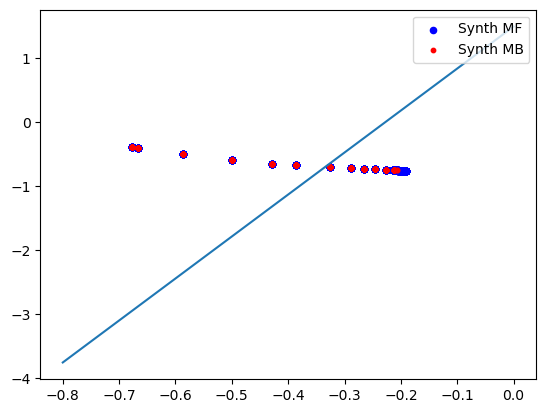

In [57]:
X_embedded_mse = torch.squeeze(model(torch.unsqueeze(torch.from_numpy(np.load(X_fname)).float(), 1))).detach().numpy()
print(X_embedded_mse.shape)

plt.figure()
mse_boundary = 500000

mf = plt.scatter(X_embedded_mse[:mse_boundary, 0], X_embedded_mse[:mse_boundary, 1], color='blue', s=20)
mb = plt.scatter(X_embedded_mse[mse_boundary:, 0], X_embedded_mse[mse_boundary:, 1], color='red', s=10)
# real = plt.scatter(real_embed[:, 0], real_embed[:, 1], color='cyan', s=5)

plt.legend((mf, mb), ('Synth MF', 'Synth MB'), loc='upper right')

X = np.linspace(-0.8, 0, 100)
m = clf.coef_.flatten()[0] / clf.coef_.flatten()[1]
b = clf.intercept_[0]

plt.plot(X, -(m*X + b))

plt.show()

In [27]:
dim = 0
print("% of MF that are over:", np.sum(X_embedded_mse[:mse_boundary, dim] > border) / X_embedded_mse[:mse_boundary, dim].size)
print("% of MB that are under:", np.sum(X_embedded_mse[mse_boundary:, dim] < border) / X_embedded_mse[mse_boundary:, dim].size)

print("% of over that are MF:",np.sum(X_embedded_mse[:mse_boundary, dim] > border) / np.sum(X_embedded_mse[:, dim] > border))
print("% of under that are MB:",np.sum(X_embedded_mse[mse_boundary:, dim] < border) / np.sum(X_embedded_mse[:, dim] < border))



% of MF that are over: 0.751042
% of MB that are under: 0.999486
% of over that are MF: 0.9993160855611558
% of under that are MB: 0.8005853686669165


In [48]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_embedded_mse, np.load(f"{bigboy.data_path}/modeling_labels.npy"))

LinearSVC(random_state=0, tol=1e-05)

In [51]:
print(clf.coef_.flatten())
print(clf.intercept_)

X = np.linspace(-1, 1, 100)
m = clf.coef_.flatten()[0] / clf.coef_.flatten()[1]
b = clf.intercept_[0]
print(m)
print(b)

[-3.87596998  0.59166668]
[-1.48725563]
-6.550934993194035
-1.4872556263942416


In [58]:
from sklearn.metrics import confusion_matrix

y_true = np.load(f"{bigboy.data_path}/modeling_labels.npy")
y_pred = clf.predict(X_embedded_mse)
confusion_matrix(y_true, y_pred)

array([[447583,  52417],
       [ 16430, 483570]])

In [211]:
embed_all = torch.squeeze(model(torch.unsqueeze(torch.from_numpy(bigboy.sigmoid_parameters).float(), 1))).detach().numpy()
idxs = np.argwhere((embed_all[:, dim] > l_border) & (embed_all[:, dim] < r_border))
boola = np.array([(i not in invalid) for i in list(idxs)])
print(boola.shape)
idxs = idxs[boola]


(62867,)


In [11]:
plt.hist(bigboy.parameter_labels[mf_cluster, 1])

NameError: name 'mf_cluster' is not defined

(500, 3)


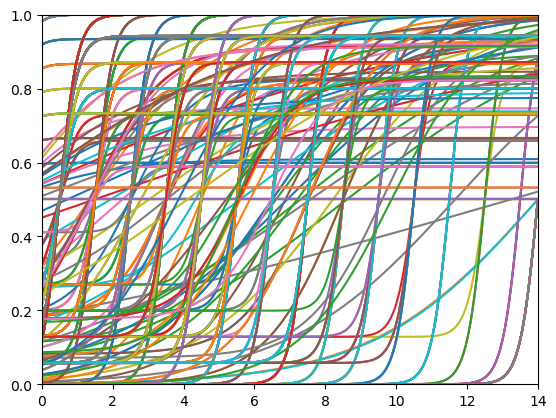

In [47]:
idxs = np.random.choice(np.arange(0, boundary), size=500, replace=True, p=None)

bigboy.visualize_sigmoids(idxs)

500000
(1000000, 3)
(1000, 3)


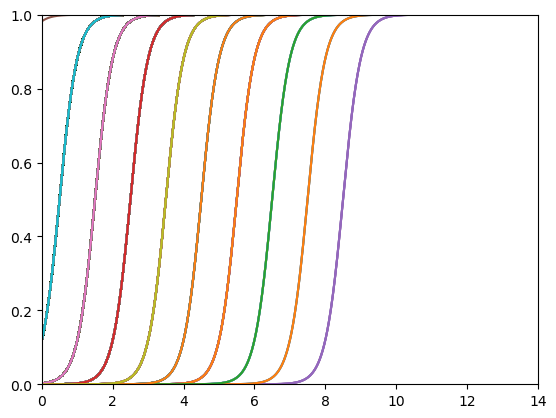

In [19]:
print(boundary)
print(bigboy.sigmoid_parameters.shape)
idxs = np.random.choice(np.arange(boundary, 1000000), size=1000, replace=True, p=None)

bigboy.visualize_sigmoids(idxs)

(50000, 3)


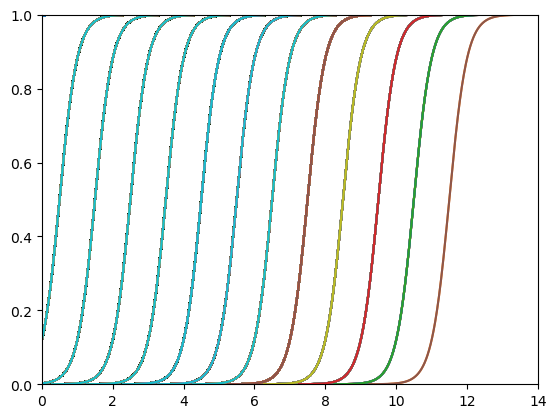

In [101]:
bigboy.visualize_sigmoids()

(array([2.0856e+04, 4.9000e+01, 1.3000e+01, 1.7000e+01, 4.0000e+00,
        9.4820e+03, 9.0000e+01, 5.9800e+02, 1.2560e+03, 1.9400e+02,
        6.1000e+01, 1.0600e+02, 6.2760e+03, 3.1000e+01, 3.0300e+02,
        6.2000e+01, 1.9800e+02, 8.3900e+02, 9.0000e+00, 3.3020e+03,
        1.6000e+01, 5.4700e+02, 3.5000e+01, 3.3000e+01, 1.2000e+01,
        1.8500e+02, 1.9940e+03, 3.0000e+00, 4.5100e+02, 5.0000e+00,
        4.0000e+00, 2.4000e+01, 2.8000e+01, 2.2500e+02, 6.6400e+02,
        2.6700e+02, 1.0000e+00, 2.0000e+00, 3.0000e+00, 5.0000e+00,
        9.0000e+00, 2.8300e+02, 1.1700e+02, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 4.0000e+00, 7.0000e+00, 1.4000e+01, 1.3150e+03]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

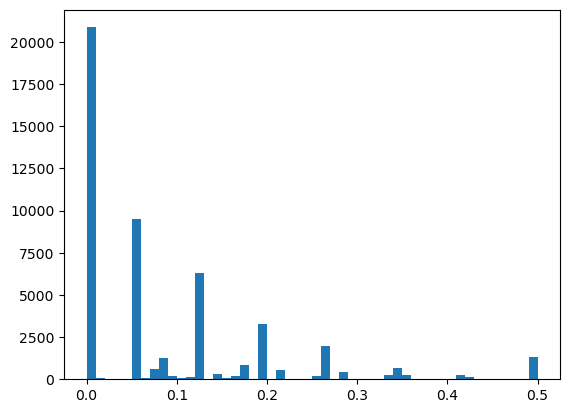

In [243]:
plt.hist(bigboy.sigmoid_parameters[:50000, 0], bins=50)

(array([9.000e+01, 2.940e+02, 4.480e+02, 7.520e+02, 4.930e+02, 7.310e+02,
        5.500e+02, 6.790e+02, 2.150e+02, 6.410e+02, 4.910e+02, 1.493e+03,
        5.100e+02, 6.760e+02, 2.790e+02, 2.160e+02, 2.060e+02, 1.100e+01,
        1.200e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.960e+02,
        1.760e+02, 1.290e+02, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.991e+04]),
 array([0.01378116, 0.09350553, 0.17322991, 0.25295429, 0.33267866,
        0.41240304, 0.49212742, 0.57185179, 0.65157617, 0.73130055,
        0.81102493, 0.8907493 , 0.97047368, 1.05019806, 1.12992243,
        1.20964681, 1.28937119, 1.36909556, 1.44881994, 1.52854432,
        1.60826869, 1.68799307, 1.76771745, 1.84744182, 1.9271662 ,
        2.00689058, 2.08661496, 2.16

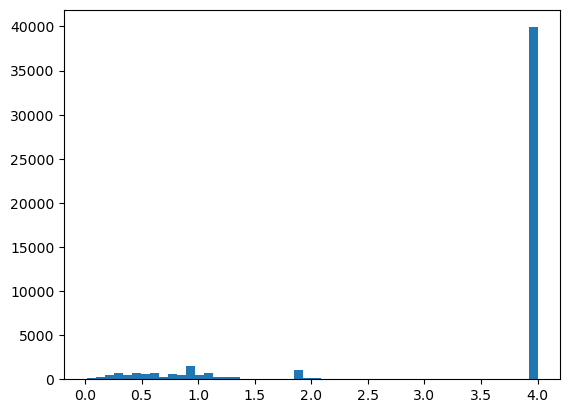

In [244]:
plt.hist(bigboy.sigmoid_parameters[:50000, 1], bins=50)

(array([20140.,  5716.,  5372.,  6614.,  3534.,  3664.,  1271.,  1422.,
          390.,  1877.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

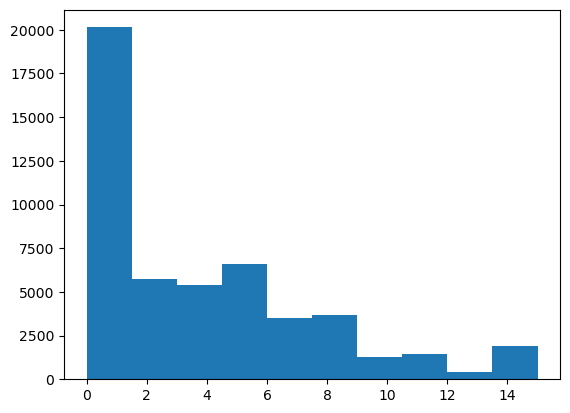

In [237]:
plt.hist(bigboy.sigmoid_parameters[:50000, 2])

(array([    0.,     0.,     0.,     0.,     0., 50000.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

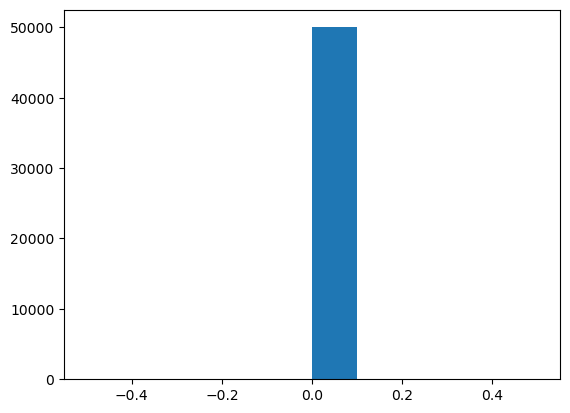

In [238]:
plt.hist(bigboy.sigmoid_parameters[50000:, 0])

(array([    0.,     0.,     0.,     0.,     0., 50000.,     0.,     0.,
            0.,     0.]),
 array([3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5]),
 <BarContainer object of 10 artists>)

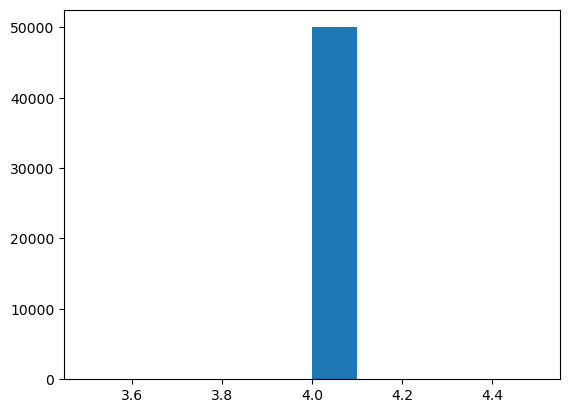

In [239]:
plt.hist(bigboy.sigmoid_parameters[50000:, 1])

(array([3.2873e+04, 1.0890e+04, 3.3660e+03, 1.9410e+03, 4.8000e+02,
        2.2300e+02, 1.1900e+02, 6.7000e+01, 2.9000e+01, 1.2000e+01]),
 array([ 0.  ,  1.15,  2.3 ,  3.45,  4.6 ,  5.75,  6.9 ,  8.05,  9.2 ,
        10.35, 11.5 ]),
 <BarContainer object of 10 artists>)

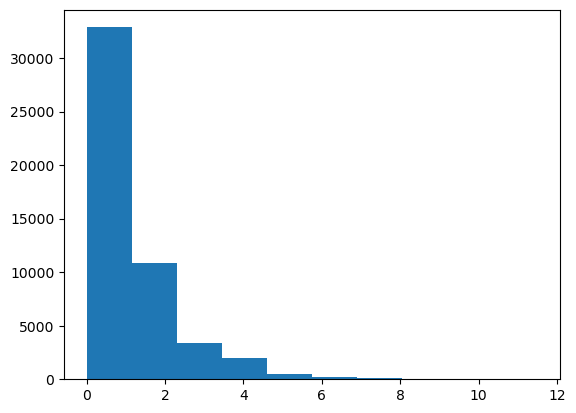

In [240]:
plt.hist(bigboy.sigmoid_parameters[50000:, 2])